## Library

In [ ]:
!pip install catboost

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from zipfile import ZipFile
import itertools
import scipy.stats as ss
import math
import datetime
import warnings
import xgboost as xgb
#import catboost as cb
#import catboost.utils as cbu
import hyperopt
import sys
from lightgbm import LGBMClassifier
import lightgbm as lgb
from scipy import interp
from sklearn import metrics as skmetrics
from sklearn import linear_model
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV,RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,auc, precision_recall_curve, confusion_matrix, recall_score, precision_score, f1_score, classification_report 
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls '/content/drive/My Drive/Colab Notebooks/Shopee_Kaggle'

Marketing_Analytics.ipynb			 order_brush_order.csv.zip
open-shopee-code-league-marketing-analytics.zip


In [9]:
filename = '/content/drive/My Drive/Colab Notebooks/Shopee_Kaggle/open-shopee-code-league-marketing-analytics.zip'

with ZipFile(filename, 'r') as zip:
  zip.printdir()
  print("Extracting...................................")
  zip.extractall()
  print("Done")

File Name                                             Modified             Size
sample_submission_0_1.csv                      2020-08-01 12:38:42       492638
test.csv                                       2020-08-01 12:38:42      4196452
train.csv                                      2020-08-01 12:38:42      5660436
users.csv                                      2020-08-01 12:38:44      4019445
Extracting...................................
Done


In [10]:
os.getcwd()

'/content'

In [11]:
train_df = pd.read_csv('train.csv')
train_df.head(2)

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,12,43,99,0,5,10,0,0
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,18,48,90,1,1,4,1,1


In [12]:
users_df = pd.read_csv('users.csv')
users_df.head(2)

,user_id,attr_1,attr_2,attr_3,age,domain
0,0,NaN,1.0,0.0,NaN,@gmail.com
1,1,1.0,1.0,2.0,50.0,@gmail.com


In [13]:
users_df.shape

(127886, 6)

In [14]:
users_df.isnull().sum()

user_id        0
attr_1     48899
attr_2       447
attr_3         0
age        48899
domain         0
dtype: int64

In [15]:
train_df[train_df.duplicated()]

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,row_id


In [16]:
users_df[users_df.duplicated()]

,user_id,attr_1,attr_2,attr_3,age,domain


In [17]:
test_df = pd.read_csv('test.csv')
test_df.head(2)

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,10,34,134,0,6,18,0
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,5,5,5,0,0,0,1


In [18]:
test_df[test_df.duplicated()]

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id


In [19]:
train_df.shape, test_df.shape, users_df.shape

((73539, 18), (55970, 17), (127886, 6))

In [20]:
train_df = pd.merge(train_df, users_df, how="left", left_on="user_id", right_on="user_id")
test_df = pd.merge(test_df, users_df, how="left", left_on="user_id", right_on="user_id")

In [21]:
train_df.shape, test_df.shape,

((73539, 23), (55970, 22))

## Train Data

### Data Types

In [ ]:
#train_df.dtypes

In [22]:
train_df['domain'].unique() , test_df['domain'].unique()

(array(['@gmail.com', '@hotmail.com', '@yahoo.com', '@icloud.com', 'other',
        '@outlook.com', '@ymail.com', '@live.com', '@163.com', '@qq.com',
        '@rocketmail.com'], dtype=object),
 array(['@gmail.com', '@yahoo.com', 'other', '@hotmail.com', '@ymail.com',
        '@rocketmail.com', '@icloud.com', '@outlook.com', '@live.com',
        '@qq.com', '@163.com'], dtype=object))

In [23]:
# change grass_date to datetime
train_df['grass_date'] = pd.to_datetime(train_df['grass_date'])
test_df['grass_date'] = pd.to_datetime(test_df['grass_date'])
display(train_df['grass_date'].head(2))
display(test_df['grass_date'].head(2))

0   2019-07-16 00:00:00+08:00
1   2019-07-16 00:00:00+08:00
Name: grass_date, dtype: datetime64[ns, pytz.FixedOffset(480)]

0   2019-09-03 00:00:00+08:00
1   2019-09-03 00:00:00+08:00
Name: grass_date, dtype: datetime64[ns, pytz.FixedOffset(480)]

In [24]:
train_df['grass_date'].describe()

count                         73539
unique                           47
top       2019-09-02 00:00:00+08:00
freq                           3915
first     2019-07-16 00:00:00+08:00
last      2019-09-02 00:00:00+08:00
Name: grass_date, dtype: object

In [25]:
test_df['grass_date'].describe()

count                         55970
unique                           26
top       2019-09-09 00:00:00+08:00
freq                           8034
first     2019-09-03 00:00:00+08:00
last      2019-09-29 00:00:00+08:00
Name: grass_date, dtype: object

In [26]:
# what to do with never open, never login and never checkout?
train_df[['last_open_day', 'last_login_day','last_checkout_day']].describe(include='O')

,last_open_day,last_login_day,last_checkout_day
count,73539,73539,73539
unique,549,893,947
top,Never open,1,Never checkout
freq,7518,10852,16905


In [30]:
#train_df[['country_code', 'last_open_day','last_login_day','last_checkout_day', 'open_flag']][(train_df['last_open_day'] == 'Never open') & (train_df['open_flag'] == 1)]
train_df[['country_code', 'last_open_day','last_login_day','last_checkout_day', 'open_flag']][(train_df['last_login_day'] > train_df['last_checkout_day']) & (train_df['open_flag'] == 1)]

,country_code,last_open_day,last_login_day,last_checkout_day,open_flag
8,1,7,5,26,1
31,4,2,6,128,1
50,4,9,6,16,1
82,5,56,4,21,1
168,2,3,8,13,1
...,...,...,...,...,...
73168,2,5,8,38,1
73292,3,5,6,26,1
73414,1,3,3,18,1
73461,2,14,2,15,1


In [31]:
activities = ['open', 'login', 'checkout']
for i in activities:
  train_df[f"last_{i}_day"] = train_df[f"last_{i}_day"].apply(lambda x: -999 if x == f"Never {i}" else int(x))
  test_df[f"last_{i}_day"] = test_df[f"last_{i}_day"].apply(lambda x: -999 if x == f"Never {i}" else int(x))

In [32]:
train_df[['last_open_day', 'last_login_day','last_checkout_day']].describe()

,last_open_day,last_login_day,last_checkout_day
count,73539.000000,73539.000000,73539.000000
mean,-72.724418,49.343233,-172.931954
std,316.914715,350.589467,465.393271
min,-999.000000,-999.000000,-999.000000
25%,3.000000,3.000000,1.000000
50%,12.000000,8.000000,12.000000
75%,33.000000,26.000000,51.000000
max,808.000000,18141.000000,1445.000000


In [34]:
#train_df[['country_code', 'last_open_day','last_login_day','last_checkout_day', 'open_flag']][(train_df['last_open_day'] == 'Never open') & (train_df['open_flag'] == 1)]
train_df[['country_code', 'last_open_day','last_login_day','last_checkout_day', 'open_flag']][(train_df['last_login_day'] > train_df['last_checkout_day']) & (train_df['open_flag'] == 1) & (train_df['last_checkout_day'] > 0)]

,country_code,last_open_day,last_login_day,last_checkout_day,open_flag
230,2,5,592,112,1
546,3,20,40,1,1
588,2,145,679,219,1
853,2,174,259,83,1
1022,2,454,313,15,1
...,...,...,...,...,...
69783,6,1,85,2,1
70190,1,33,4,3,1
71454,5,7,5,2,1
71885,2,5,35,4,1


### Data Quality

In [ ]:
def get_summary_df(df, sort_type="dtype"):
    '''
    input:
        df -> dataframe
        sort_type -> one of (dtype, unique_count, missing_count, missing_percentage, total_count)
    return: df info of each column consist of ->
        dtype, unique_count, missing_count, missing_percentage, total_count
    '''
    def _get_info(df, column):
        '''
            edit here to add more information of columns!
        '''
        df_column = df[column]
        #--------------------------------------------------------------
        # info
        dtype = str(df_column.dtype)
        unique_count = df_column.nunique()
        missing_count = df_column.isnull().sum()
        missing_percentage = round((missing_count/df.shape[0]) * 100, 2)
        #--------------------------------------------------------------
        return dtype, unique_count, missing_count, missing_percentage
    
    columns = df.columns.tolist()
    dtypes = []
    unique_counts = []
    missing_counts = []
    missing_percentages = []
    total_counts = [df.shape[0]] * len(columns)

    for column in columns:
        dtype, unique_count, missing_count, missing_percentage = _get_info(df, column) # get info
        dtypes.append(dtype)
        unique_counts.append(unique_count)
        missing_counts.append(missing_count)
        missing_percentages.append(missing_percentage)
        

    summary_df = pd.DataFrame({
        "column": columns,
        "dtype": dtypes,
        "unique_count": unique_counts,
        "missing_count": missing_counts,
        "missing_percentage": missing_percentages,
        "total_count": total_counts,
    })
    summary_df = summary_df.sort_values(by=sort_type, ascending=False).reset_index(drop=True)
    
    return summary_df

In [ ]:
get_summary_df(train_df)

,column,dtype,unique_count,missing_count,missing_percentage,total_count
0,domain,object,11,0,0.00,73539
1,open_count_last_60_days,int64,76,0,0.00,73539
2,row_id,int64,73539,0,0.00,73539
3,open_flag,int64,2,0,0.00,73539
4,checkout_count_last_60_days,int64,219,0,0.00,73539
5,checkout_count_last_30_days,int64,142,0,0.00,73539
6,checkout_count_last_10_days,int64,71,0,0.00,73539
7,login_count_last_60_days,int64,637,0,0.00,73539
8,login_count_last_10_days,int64,168,0,0.00,73539
9,country_code,int64,7,0,0.00,73539


In [ ]:
get_summary_df(test_df)

,column,dtype,unique_count,missing_count,missing_percentage,total_count
0,domain,object,11,0,0.00,55970
1,open_count_last_60_days,int64,77,0,0.00,55970
2,row_id,int64,55970,0,0.00,55970
3,checkout_count_last_60_days,int64,202,0,0.00,55970
4,checkout_count_last_30_days,int64,131,0,0.00,55970
5,checkout_count_last_10_days,int64,67,0,0.00,55970
6,login_count_last_60_days,int64,615,0,0.00,55970
7,login_count_last_10_days,int64,166,0,0.00,55970
8,country_code,int64,7,0,0.00,55970
9,open_count_last_30_days,int64,41,0,0.00,55970


In [ ]:
#count_never_open = train_df[['last_open_day']][train_df['last_open_day'] == 'Never open'].count()
count_never_open = train_df[['last_open_day']][train_df['last_open_day'] < 0].count()
pct_never_open = count_never_open / train_df.shape[0] * 100 
print("Number of customers who never open email: ", count_never_open)
print("Percentage of customers who never open email:  ", pct_never_open )

Number of customers who never open email:  last_open_day    7518
dtype: int64
Percentage of customers who never open email:   last_open_day    10.223147
dtype: float64


In [ ]:
#count_never_login = train_df[['last_login_day']][train_df['last_login_day'] == 'Never login'].count()
count_never_login = train_df[['last_login_day']][train_df['last_login_day'] < 0].count()
pct_never_login = count_never_login / train_df.shape[0] * 100 
print("Number of customers who never login: ", count_never_login)
print("Percentage of customers who never login:  ", pct_never_login )

Number of customers who never login:  last_login_day    279
dtype: int64
Percentage of customers who never login:   last_login_day    0.379391
dtype: float64


In [ ]:
#count_never_checkout = train_df[['last_checkout_day']][train_df['last_checkout_day'] == 'Never checkout'].count()
count_never_checkout = train_df[['last_checkout_day']][train_df['last_checkout_day'] < 0].count()
pct_never_checkout = count_never_checkout / train_df.shape[0] * 100 
print("Number of customers who never checkout: ", count_never_checkout)
print("Percentage of customers who never checkout:  ", pct_never_checkout )

Number of customers who never checkout:  last_checkout_day    16905
dtype: int64
Percentage of customers who never checkout:   last_checkout_day    22.987802
dtype: float64


In [ ]:
train_df[['attr_1', 'attr_2', 'attr_3', 'age']].describe()

,attr_1,attr_2,attr_3,age
count,45347.000000,73260.000000,73539.000000,45347.000000
mean,0.999757,0.997256,1.077863,31.445564
std,0.015573,0.052308,1.035252,11.797405
min,0.000000,0.000000,0.000000,-17.000000
25%,1.000000,1.000000,0.000000,24.000000
50%,1.000000,1.000000,1.000000,29.000000
75%,1.000000,1.000000,2.000000,36.000000
max,1.000000,1.000000,4.000000,118.000000


In [ ]:
test_df[['attr_1', 'attr_2', 'attr_3', 'age']].describe()

,attr_1,attr_2,attr_3,age
count,34737.000000,55802.000000,55970.000000,34737.000000
mean,0.999885,0.999032,1.085778,31.267409
std,0.010730,0.031093,1.035913,11.312572
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,24.000000
50%,1.000000,1.000000,1.000000,29.000000
75%,1.000000,1.000000,2.000000,36.000000
max,1.000000,1.000000,4.000000,118.000000


In [ ]:
for i in ['attr_1', 'attr_2', 'attr_3', 'age']:
  train_df[i] = train_df[i].fillna(-999)

In [ ]:
#get_summary_df(test_df)

In [ ]:
#train_df[train_df['last_login_day'] > 10000].describe()

### Target Proportion

In [ ]:
train_df['open_flag'].value_counts(normalize=True)

0    0.844219
1    0.155781
Name: open_flag, dtype: float64

### Distribution Comparison between Target Values 

In [ ]:
#sns.pairplot(train_df, hue='open_flag')

In [ ]:
open_df = train_df[train_df['open_flag'] == 1]
ntopen_df = train_df[train_df['open_flag'] == 0]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


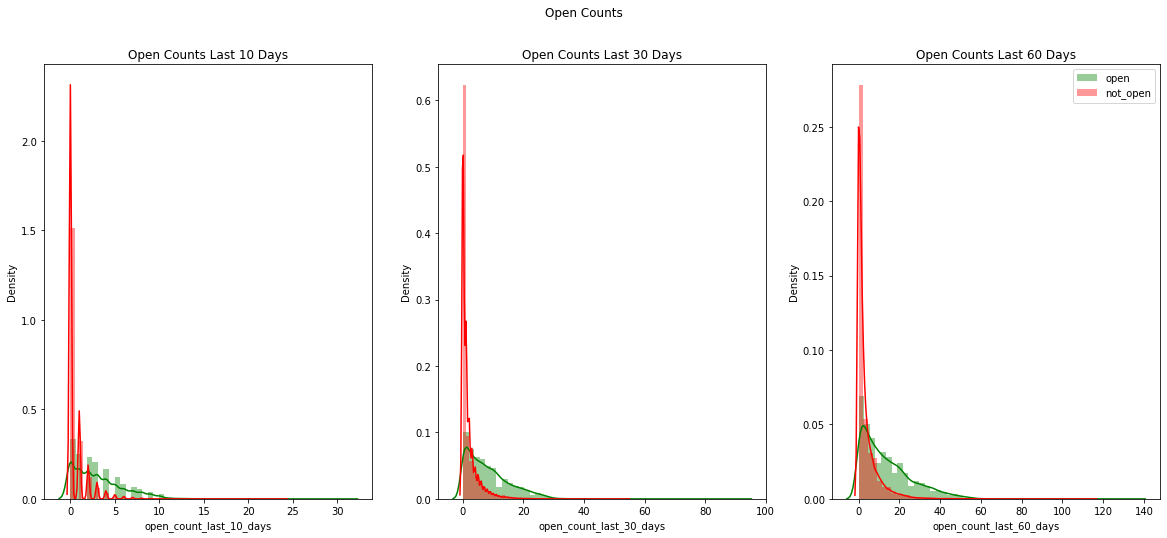

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Open Counts")

# last 10 days
sns.distplot(open_df['open_count_last_10_days'], color='g', label='open', ax=axes[0])
sns.distplot(ntopen_df['open_count_last_10_days'], color='r', label='not_open', ax=axes[0])
axes[0].set_title("Open Counts Last 10 Days")
plt.legend()

# last 30 days
sns.distplot(open_df['open_count_last_30_days'], color='g', hist=True, label='open', ax=axes[1])
sns.distplot(ntopen_df['open_count_last_30_days'], color='r', hist=True, label='not_open', ax=axes[1])
axes[1].set_title("Open Counts Last 30 Days")
plt.legend()

# last 60 days
sns.distplot(open_df['open_count_last_60_days'], color='g', hist=True, label='open', ax=axes[2])
sns.distplot(ntopen_df['open_count_last_60_days'], color='r', hist=True, label='not_open', ax=axes[2])
axes[2].set_title("Open Counts Last 60 Days")
plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


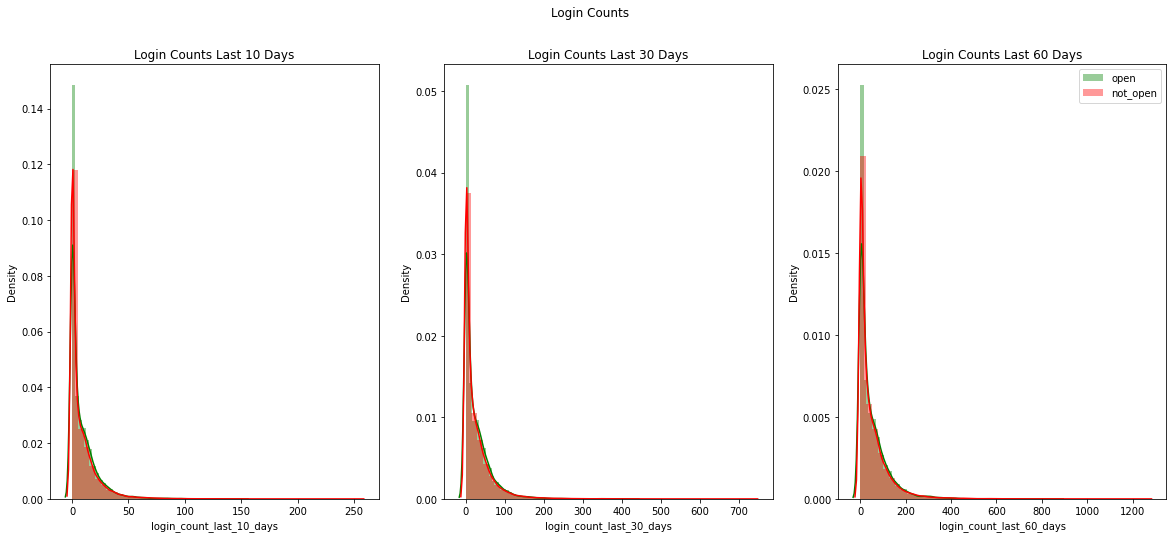

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Login Counts")

# last 10 days
sns.distplot(open_df['login_count_last_10_days'], color='g', label='open', ax=axes[0])
sns.distplot(ntopen_df['login_count_last_10_days'], color='r', label='not_open', ax=axes[0])
axes[0].set_title("Login Counts Last 10 Days")
plt.legend()

# last 30 days
sns.distplot(open_df['login_count_last_30_days'], color='g', hist=True, label='open', ax=axes[1])
sns.distplot(ntopen_df['login_count_last_30_days'], color='r', hist=True, label='not_open', ax=axes[1])
axes[1].set_title("Login Counts Last 30 Days")
plt.legend()

# last 60 days
sns.distplot(open_df['login_count_last_60_days'], color='g', hist=True, label='open', ax=axes[2])
sns.distplot(ntopen_df['login_count_last_60_days'], color='r', hist=True, label='not_open', ax=axes[2])
axes[2].set_title("Login Counts Last 60 Days")
plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


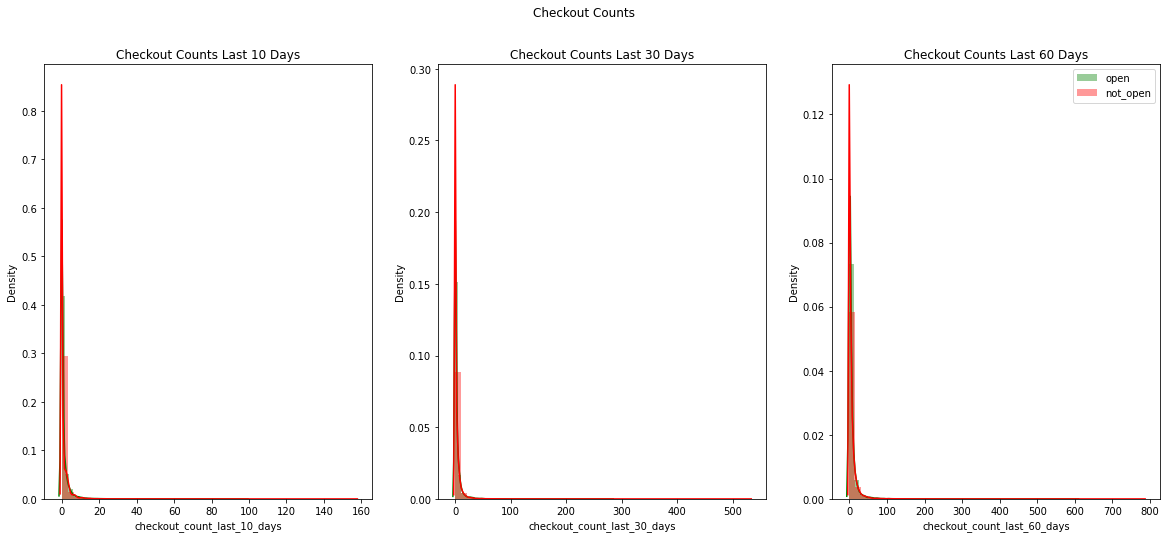

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Checkout Counts")

# last 10 days
sns.distplot(open_df['checkout_count_last_10_days'], color='g', label='open', ax=axes[0])
sns.distplot(ntopen_df['checkout_count_last_10_days'], color='r', label='not_open', ax=axes[0])
axes[0].set_title("Checkout Counts Last 10 Days")
plt.legend()

# last 30 days
sns.distplot(open_df['checkout_count_last_30_days'], color='g', hist=True, label='open', ax=axes[1])
sns.distplot(ntopen_df['checkout_count_last_30_days'], color='r', hist=True, label='not_open', ax=axes[1])
axes[1].set_title("Checkout Counts Last 30 Days")
plt.legend()

# last 60 days
sns.distplot(open_df['checkout_count_last_60_days'], color='g', hist=True, label='open', ax=axes[2])
sns.distplot(ntopen_df['checkout_count_last_60_days'], color='r', hist=True, label='not_open', ax=axes[2])
axes[2].set_title("Checkout Counts Last 60 Days")
plt.legend()


### Categorical Encoding

In [ ]:
def freq_encoding(df, cols):
    for col in cols:
        enc_col = (df.groupby(col).size()) / len(df)
        df[col] = df[col].apply(lambda x : enc_col[x])
    return df

def ohe_encoding(df, cols):
    df = pd.get_dummies(df, columns = cols,prefix_sep='_')
    return df

## Metrics

In [ ]:
class RegressionMetrics:
  def __init__(self):
    self.metrics = {
        "mae": self._mae,
        "mse": self._mse,
        "rmse": self._rmse,
        "msle": self._msle,
        "rmsle": self._rmsle,
        "r2": self._r2
    }

  def __call__(self, metric, y_true, y_pred):
    if metric not in self.metrics:
      raise Exception("Metric not implemented")
    if metric == "mae":
      return self._mae(y_true, y_pred)
    if metric == "mse":
      return self._mse(y_true, y_pred)
    if metric == "rmse":
      return self._rmse(y_true, y_pred)
    if metric == "msle":
      return self._msle(y_true, y_pred)
    if metric == "rmsle":
      return self._rmsle(y_true, y_pred)
    if metric == "r2":
      return self._r2(y_true, y_pred)
    
  @staticmethod
  def _mae(y_true, y_pred):
    return skmetrics.mean_absolute_error(y_true, y_pred)

  @staticmethod
  def _mse(y_true, y_pred):
    return skmetrics.mean_squared_error(y_true, y_pred)

  def _rmse(self, y_true, y_pred):
    return np.sqrt(self._mse(y_true, y_pred))

  @staticmethod
  def _msle(y_true, y_pred):
    return skmetrics.mean_squared_log_error(y_true, y_pred)

  def _rmsle(self, y_true, y_pred):
    return np.sqrt(self._msle(y_true, y_pred))

  @staticmethod
  def _r2(y_true, y_pred):
    return skmetrics.r2_score(y_true, y_pred)


class ClassificationMetrics:
  def __init__(self):
    self.metrics = {
        "accuracy": self._accuracy,
        "f1": self._f1,
        "precision": self._precision,
        "recall":self._recall, 
        "auc":self._auc, 
        "logloss": self._logloss,
        "matthews_corrcoef": self._matthews_corrcoef
    }

  def __call__(self, metric, y_true, y_pred, y_proba=None):
    if metric not in self.metrics:
      raise Exception("Metric not implemented")
    if metric == 'auc':
      if y_proba is not None:
        return self._auc(y_true=y_true, y_pred = y_proba)
      else:
        raise Exception("y_proba cannot be None for AUC")
    elif metric == 'logloss':
      if y_proba is not None:
        return self._logloss(y_true=y_true, y_pred=y_proba)
      else:
        raise Exception("y_proba cannot be None for logloss")
    else:
      return self.metrics[metric](y_true=y_true, y_pred=y_pred)

  @staticmethod
  def _auc(y_true, y_pred):
    return skmetrics.roc_auc_score(y_true=y_true, y_score=y_pred)

  @staticmethod
  def _accuracy(y_true, y_pred):
    return skmetrics.accuracy_score(y_true=y_true, y_pred=y_pred)

  @staticmethod
  def _f1(y_true, y_pred):
    return skmetrics.f1_score(y_true=y_true, y_pred = y_pred)
  
  @staticmethod
  def _recall(y_true, y_pred):
    return skmetrics.recall_score(y_true=y_true, y_pred = y_pred)
  
  @staticmethod
  def _precision(y_true, y_pred):
    return skmetrics.precision_score(y_true=y_true, y_pred = y_pred)

  @staticmethod
  def _logloss(y_true, y_pred):
    return skmetrics.log_loss(y_true=y_true, y_pred = y_pred)

  @staticmethod
  def _matthews_corrcoef(y_true, y_pred):
    return skmetrics.matthews_corrcoef(y_true=y_true, y_pred = y_pred)


## Modeling

### Simple Logistic Regression

In [ ]:
y_true = train_df['open_flag'][train_len:]
y_proba = preds
ClassificationMetrics()("auc", y_true, y_pred, y_pred)

0.5

In [ ]:
ClassificationMetrics()("precision", y_true, y_pred, y_pred)

0.0

In [ ]:
ClassificationMetrics()("recall", y_true, y_pred, y_pred)

0.0

In [ ]:
ClassificationMetrics()("logloss", y_true, y_pred, y_pred)

5.100504645753739

In [ ]:
ClassificationMetrics()("f1", y_true, y_pred, y_pred)

0.0

In [ ]:
ClassificationMetrics()("matthews_corrcoef", y_true, y_pred, y_pred)

0.0

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_true, y_pred)

0.49572187061048706

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=y_true, y_score=y_pred)

0.7018483636372184

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true=y_true, y_pred = y_pred)

0.5374574347332577

## Gradient Boosting

In [ ]:
#train_df.dtypes

In [ ]:
train_df2 = train_df.drop(['user_id', 'row_id', 'grass_date'], axis=1)
train_df.shape, train_df2.shape

((73539, 23), (73539, 20))

In [ ]:
def ohe_encoding(df, cols):
    df = pd.get_dummies(df, columns = cols,prefix_sep='_')
    return df

train_df2 = ohe_encoding(train_df2, ['domain'])

In [ ]:
train_df2.shape

(73539, 30)

In [ ]:
train_df2 = train_df2.reindex(np.random.permutation(train_df2.index))
train_df3, test_df3 = train_test_split(train_df2, test_size=0.3, random_state=42)
train_df3.shape, test_df3.shape

((51477, 30), (22062, 30))

### XGB

In [ ]:
features = list(train_df3)
features.remove('open_flag')
target = 'open_flag'
print("features dimension: ", len(features))


features dimension:  29


features dimension:  29

fold 1
[0]	Train-auc:0.865267	Val-auc:0.857108
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 100 rounds.
[100]	Train-auc:0.890326	Val-auc:0.877074
[200]	Train-auc:0.896673	Val-auc:0.878228
[300]	Train-auc:0.902015	Val-auc:0.879231
[400]	Train-auc:0.907577	Val-auc:0.879952
[499]	Train-auc:0.912425	Val-auc:0.880441

fold 2
[0]	Train-auc:0.878189	Val-auc:0.859139
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 100 rounds.
[100]	Train-auc:0.893329	Val-auc:0.867496
[200]	Train-auc:0.900129	Val-auc:0.868724
Stopping. Best iteration:
[146]	Train-auc:0.8971	Val-auc:0.869021


fold 3
[0]	Train-auc:0.878701	Val-auc:0.865366
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 100 rounds.
[100]	Train-auc:0.890486	Val-auc:0.870942
[200]	Tra

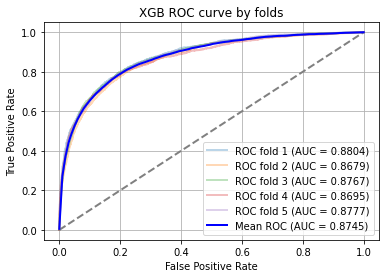

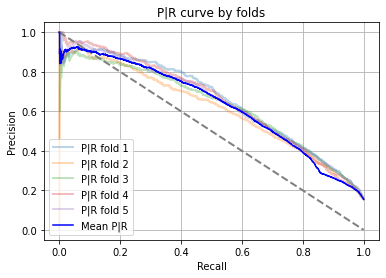

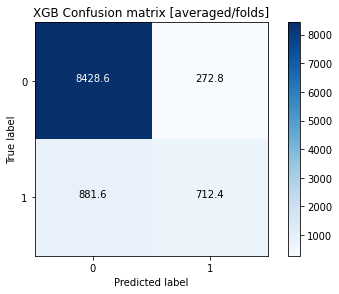

CPU times: user 1min 34s, sys: 7.26 s, total: 1min 41s
Wall time: 1min


In [ ]:
%%time

xgb_params = {'eta': 0.005, 'n_estimators':1000,
              'max_depth': 9, 'subsample': 1, 'colsample_bytree': 1, 'min_child_weight' :7,
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True,
          'tree_method':'gpu_hist',
          #'scale_pos_weight': neg_pos,
        
          }

plt.rcParams["axes.grid"] = True

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df3))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_scores = []
f1_scores = []
accuracies = []
precisions = []
#matthews_corrcoef = []

predictions = np.zeros(len(test_df3))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df3, train_df3.open_flag.values):
    print("\nfold {}".format(i))
    trn_data = xgb.DMatrix(train_df3.iloc[train_idx][features],
                                   label=train_df3.iloc[train_idx][target],feature_names=features
                                   )
    val_data = xgb.DMatrix(train_df3.iloc[valid_idx][features],
                                   label=train_df3.iloc[valid_idx][target],feature_names=features
                                   )   
    
    clf = xgb.train(xgb_params, dtrain=trn_data, num_boost_round = 500, evals = [(trn_data, "Train"), (val_data, "Val")], early_stopping_rounds = 100, verbose_eval = 100)
    oof[valid_idx] = clf.predict(xgb.DMatrix(train_df3.iloc[valid_idx][features])) 
    
    predictions += clf.predict(xgb.DMatrix(test_df3[features])) / nfold
    
    # Scores 
    roc_scores.append(roc_auc_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df3.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    #matthews_corrcoef.append(matthews_corrcoef(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df3.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df3.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df3.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["importance"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_scores), np.std(roc_scores)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores)),
        #'\nCV matthews_corrcoef: {0:.4f}, std: {1:.4f}.'.format(np.mean(matthews_corrcoef), np.std(matthews_corrcoef)) 
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_scores)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'XGB Confusion matrix [averaged/folds]')
plt.show()


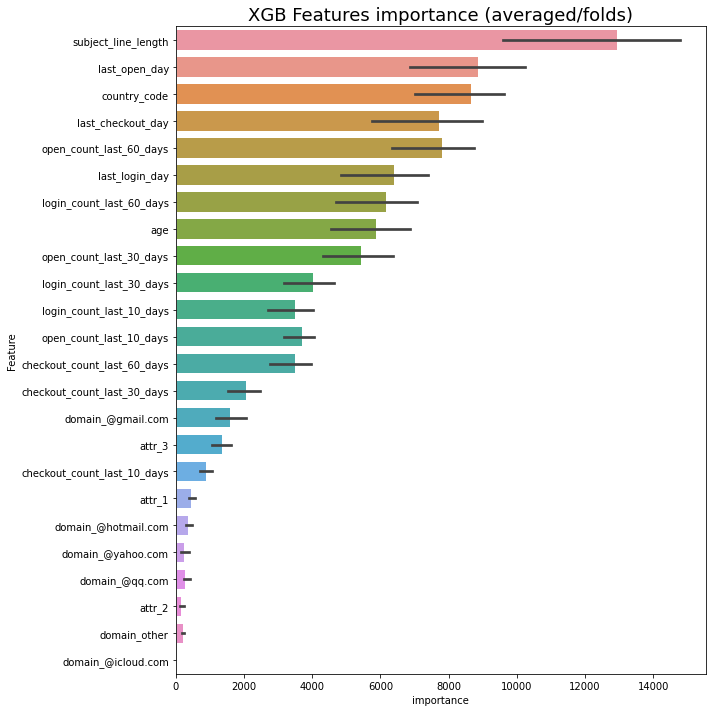

In [ ]:
#features
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2) #palette="rocket")
plt.title('XGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [ ]:
test_data = xgb.DMatrix(test_df3[features],
                                   label=test_df3[target],feature_names=features
                                   )   
predictions = clf.predict(xgb.DMatrix(test_df3[features]))
print("AUC: ",roc_auc_score(test_df3[target].values, predictions))
print("accuracies: ", (accuracy_score(test_df3[target].values, predictions.round())))
print("recalls: ",(recall_score(test_df3[target].values, predictions.round())))
print("precisions: ",(precision_score(test_df3[target].values, predictions.round())))
print("f1_scores: ",(f1_score(test_df3[target].values, predictions.round())))
print("matthews_corrcoef: ",(matthews_corrcoef(test_df3[target].values, predictions.round())))

AUC:  0.876117133107303
accuracies:  0.887272232798477
recalls:  0.45438898450946646
precisions:  0.7302904564315352
f1_scores:  0.560212201591512
matthews_corrcoef:  0.5180768767422029


### LightGBM

In [ ]:
'''
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake ../../LightGBM
!make -j4
'''

'\n!git clone --recursive https://github.com/Microsoft/LightGBM\n%cd LightGBM\n!mkdir build\n%cd build\n!cmake ../../LightGBM\n!make -j4\n'

In [ ]:
! git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;  

Cloning into 'LightGBM'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 19899 (delta 66), reused 56 (delta 29), pack-reused 19778
Receiving objects: 100% (19899/19899), 15.83 MiB | 27.29 MiB/s, done.
Resolving deltas: 100% (14489/14489), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 26.32 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc

In [ ]:
#train_df2 = train_df2.reindex(np.random.permutation(train_df2.index))
#train_df3, test_df3 = train_test_split(train_df2, test_size=0.3, random_state=42)
features = list(train_df3)
features.remove('open_flag')
target = 'open_flag'
print("features dimension: ", len(features))

features dimension:  29


In [ ]:
param_lgb = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'binary',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         'metric':'auc',
         'device_type':'gpu',
         #"lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5,
         #'reg_alpha': 1.0,
         #'reg_lambda': 0.31,
         'subsample': 0.9,}


fold 1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.883713	valid_1's auc: 0.874464
[200]	training's auc: 0.891274	valid_1's auc: 0.877355
[300]	training's auc: 0.897729	valid_1's auc: 0.878745
[400]	training's auc: 0.903629	valid_1's auc: 0.879624
[500]	training's auc: 0.908101	valid_1's auc: 0.880248
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.908101	valid_1's auc: 0.880248

fold 2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.882079	valid_1's auc: 0.872537
[200]	training's auc: 0.889804	valid_1's auc: 0.876669
[300]	training's auc: 0.896565	valid_1's auc: 0.878995
[400]	training's auc: 0.902862	valid_1's auc: 0.879931
[500]	training's auc: 0.9080

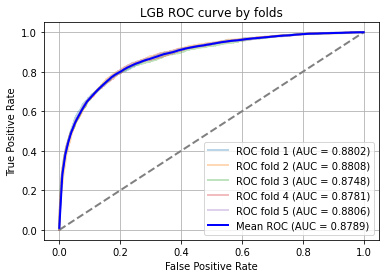

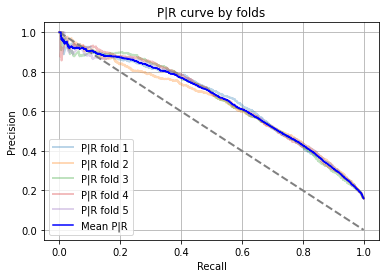

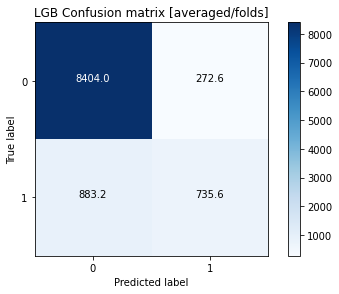

In [ ]:
plt.rcParams["axes.grid"] = True

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df3))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df3))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train_df3, train_df3.open_flag.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train_df3.iloc[train_idx][features].values,
                                   label=train_df3.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train_df3.iloc[valid_idx][features].values,
                                   label=train_df3.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 500, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train_df3.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test_df3[features]) / nfold
    
    # Scores 
    roc_aucs.append(roc_auc_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df3.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df3.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df3.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df3.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df3.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")


# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'LGB Confusion matrix [averaged/folds]')
plt.show()


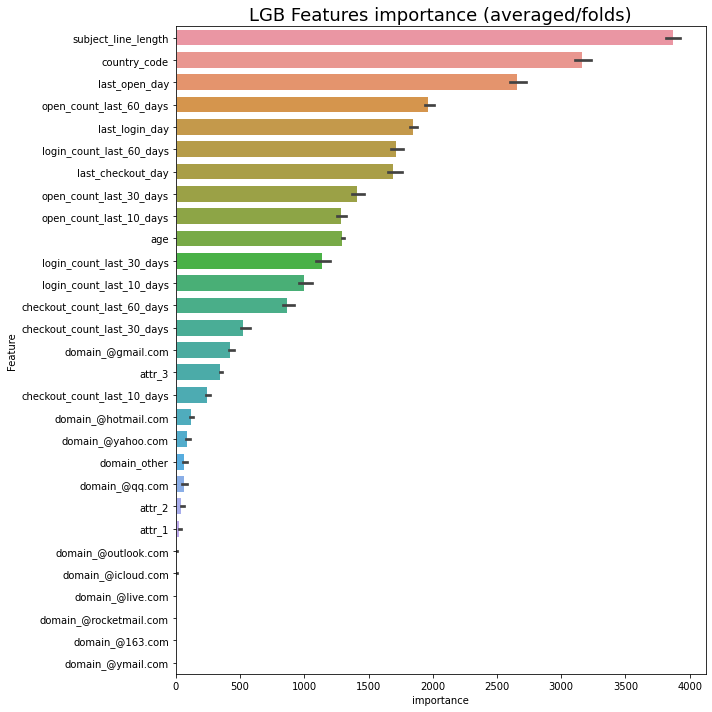

In [ ]:
#plt.style.use('dark_background')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2) #palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [ ]:
test_data = lgb.Dataset(test_df3[features],
                                   label=test_df3[target]
                                   )   


predictions = clf.predict(test_df3[features])
print("AUC: ",roc_auc_score(test_df3[target].values, predictions))
print("accuracies: ", (accuracy_score(test_df3[target].values, predictions.round())))
print("recalls: ",(recall_score(test_df3[target].values, predictions.round())))
print("precisions: ",(precision_score(test_df3[target].values, predictions.round())))
print("f1_scores: ",(f1_score(test_df3[target].values, predictions.round())))
print("matthews_corrcoef: ",(matthews_corrcoef(test_df3[target].values, predictions.round())))

AUC:  0.8824169627831663
accuracies:  0.8917595866195268
recalls:  0.4693634741225461
precisions:  0.7231897341888176
f1_scores:  0.5692640692640693
matthews_corrcoef:  0.5261737034337691


### CatBoost

In [ ]:
!pip install -q numpy pandas catboost hyperopt scikit-learn matplotlib

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
print(catboost.__version__)

0.24.2


In [ ]:

train_df2 = train_df.drop(['user_id', 'row_id', 'grass_date'], axis=1)
train_df2 = ohe_encoding(train_df2, ['domain'])
train_df2 = train_df2.reindex(np.random.permutation(train_df2.index))
train_df3, test_df3 = train_test_split(train_df2, test_size=0.3, random_state=42)

X = train_df3.drop('open_flag', axis=1)
y = train_df3['open_flag']

In [ ]:
#categorical_features_indices = np.where(X.dtypes != np.float)[0]
#categorical_features_indices

In [ ]:
from catboost import CatBoostClassifier, Pool, cv

#train_pool = Pool(data=train_df2[features], label=train_df2['open_flag'].values, has_header=True)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X, y,
    #cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.1

cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.598718,0.000651,0.598644,0.000477,0.837747,0.006266
1,1,0.535457,0.002547,0.535241,0.002737,0.844814,0.004839
2,2,0.484219,0.002117,0.483839,0.001734,0.847899,0.004560
3,3,0.443157,0.001809,0.442734,0.001092,0.850076,0.004688
4,4,0.413029,0.002256,0.412501,0.001744,0.850739,0.004441


In [ ]:
X_test = test_df3.drop('open_flag', axis=1)
y_test = test_df3['open_flag']
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
predictions_probs


array([0.02863041, 0.03446763, 0.02408637, ..., 0.02953448, 0.19364398,
       0.09703174])

In [ ]:
print("AUC: ",roc_auc_score(y_test.values, predictions_probs))
print("accuracies: ", (accuracy_score(y_test.values, predictions)))
print("recalls: ",(recall_score(y_test.values, predictions)))
print("precisions: ",(precision_score(y_test.values, predictions)))
print("f1_scores: ",(f1_score(y_test.values, predictions)))
print("matthews_corrcoef: ",(matthews_corrcoef(y_test.values, predictions)))

AUC:  0.8717598800616139
accuracies:  0.8885413833741275
recalls:  0.46497549726145865
precisions:  0.7278880866425993
f1_scores:  0.5674582233948988
matthews_corrcoef:  0.5238244213168243


## SMOTE